# LOAD DATA TEST

In [29]:
!pip install torch torchvision matplotlib opencv-python
!pip install ultralytics
!pip install datasets

In [30]:
from datasets import load_dataset
from PIL import Image
from torchvision import transforms

dataset_name = "katanaml-org/invoices-donut-data-v1"
image_path = None

try:
    eval_dataset = load_dataset(dataset_name, split="train")

    if len(eval_dataset) > 0:
        first_item = eval_dataset[0]
        image_path = first_item['image']

        # Pastikan gambar dalam format RGB
        if image_path.mode != 'RGB':
            image_path = image_path.convert('RGB')

        print(f"Berhasil memuat gambar pertama dari split 'eval' dataset '{dataset_name}'.")
        print(f"Ukuran gambar: {image_path.size}")

    else:
        print(f"Split 'eval' dari dataset '{dataset_name}' kosong atau tidak dapat diakses.")

except Exception as e:
    print(f"Terjadi kesalahan saat memuat atau mengakses dataset: {e}")

Berhasil memuat gambar pertama dari split 'eval' dataset 'katanaml-org/invoices-donut-data-v1'.
Ukuran gambar: (2481, 3508)


# GRAD CAM

In [31]:
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ultralytics import YOLO
from torchvision import transforms

In [32]:
model = YOLO("/kaggle/input/model_fix/other/default/1/best.pt")

In [33]:
print("\n--- Layers in `model.model` (potential target_layer_name candidates) ---")
try:
    # Loop melalui generator yang dikembalikan oleh model.model.named_modules()
    for name, module in model.model.named_modules():
        # Anda bisa menambahkan filter di sini jika daftarnya terlalu panjang
        # Misalnya, hanya tampilkan layer yang relevan untuk Grad-CAM
        if isinstance(module, torch.nn.Conv2d) or \
           'Conv' in str(type(module).__name__) or \
           'C3'   in str(type(module).__name__) or \
           'SPPF' in str(type(module).__name__) or \
           'Bottleneck' in str(type(module).__name__):
            print(f"Name: '{name}', Module: {type(module).__name__}")
except AttributeError:
    print("Error: 'model.model' tidak ditemukan atau bukan nn.Module. Pastikan model sudah di-load dengan benar.")
    print("Jika model Anda adalah objek YOLO dari Ultralytics, 'model.model' seharusnya adalah modul PyTorch internal.")
except Exception as e:
    print(f"Terjadi error saat mengakses layer: {e}")

print("---------------------------------------------------------------------\n")


--- Layers in `model.model` (potential target_layer_name candidates) ---
Name: 'model.0', Module: Conv
Name: 'model.0.conv', Module: Conv2d
Name: 'model.1', Module: Conv
Name: 'model.1.conv', Module: Conv2d
Name: 'model.2.cv1', Module: Conv
Name: 'model.2.cv1.conv', Module: Conv2d
Name: 'model.2.cv2', Module: Conv
Name: 'model.2.cv2.conv', Module: Conv2d
Name: 'model.2.m.0', Module: Bottleneck
Name: 'model.2.m.0.cv1', Module: Conv
Name: 'model.2.m.0.cv1.conv', Module: Conv2d
Name: 'model.2.m.0.cv2', Module: Conv
Name: 'model.2.m.0.cv2.conv', Module: Conv2d
Name: 'model.3', Module: Conv
Name: 'model.3.conv', Module: Conv2d
Name: 'model.4.cv1', Module: Conv
Name: 'model.4.cv1.conv', Module: Conv2d
Name: 'model.4.cv2', Module: Conv
Name: 'model.4.cv2.conv', Module: Conv2d
Name: 'model.4.m.0', Module: Bottleneck
Name: 'model.4.m.0.cv1', Module: Conv
Name: 'model.4.m.0.cv1.conv', Module: Conv2d
Name: 'model.4.m.0.cv2', Module: Conv
Name: 'model.4.m.0.cv2.conv', Module: Conv2d
Name: 'model.

In [34]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import gc

# --- Kelas GradCAM ---
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model_wrapper = model # Objek YOLO dari Ultralytics
        self.actual_model_module = model.model # nn.Module internal (misal, DetectionModel)
        self.target_layer_name = target_layer_name
        self.feature_maps = None
        self.gradients = None

        self.actual_model_module.eval()
        self._register_hooks()

    def _register_hooks(self):
        found_layer = False
        # Mencari di dalam self.actual_model_module (model.model)
        for name, module in self.actual_model_module.named_modules():
            if name == self.target_layer_name:
                # (Definisi forward_hook dan backward_hook sama seperti sebelumnya)
                def forward_hook(module, input, output):
                    self.feature_maps = output.detach()
                def backward_hook(module, grad_input, grad_output):
                    self.gradients = grad_output[0].detach()

                module.register_forward_hook(forward_hook)
                module.register_full_backward_hook(backward_hook)
                found_layer = True
                print(f"Hooks registered on layer: {self.target_layer_name} within {type(self.actual_model_module).__name__}")
                break
        
        if not found_layer:
            # Jika tidak ketemu di model.model, coba di model_wrapper (objek YOLO utama)
            # Ini untuk kasus jika target_layer_name menyertakan prefix 'model.'
            print(f"Layer '{self.target_layer_name}' not found directly in '{type(self.actual_model_module).__name__}'. Trying in YOLO object root...")
            for name, module in self.model_wrapper.named_modules():
                 if name == self.target_layer_name:
                    def forward_hook(module, input, output): # Perlu didefinisikan ulang di scope ini
                        self.feature_maps = output.detach()
                    def backward_hook(module, grad_input, grad_output): # Perlu didefinisikan ulang
                        self.gradients = grad_output[0].detach()
                    
                    module.register_forward_hook(forward_hook)
                    module.register_full_backward_hook(backward_hook)
                    found_layer = True
                    print(f"Hooks registered on layer: {self.target_layer_name} within {type(self.model_wrapper).__name__} (root)")
                    break
        
        if not found_layer:
            raise ValueError(
                f"Target layer '{self.target_layer_name}' not found. \n"
                f"Please inspect `model.model.named_modules()` and `model.named_modules()`."
            )

    def _get_target_score_for_detection(self, list_of_head_outputs, target_class_id, device):
        total_score = torch.tensor(0.0, device=device, requires_grad=True)
        
        if not list_of_head_outputs: # Jika list_of_head_outputs kosong
            print("DEBUG: list_of_head_outputs is empty. Returning zero score.")
            return total_score

        # Dapatkan nc (jumlah kelas) dari model
        # self.actual_model_module adalah DetectionModel, yang biasanya punya atribut .nc
        num_classes_from_model = self.actual_model_module.nc if hasattr(self.actual_model_module, 'nc') else 80
        print(f"DEBUG _get_target_score_for_detection: num_classes_from_model (nc) = {num_classes_from_model}")
        # Untuk YOLOv8, format outputnya: box(4) + cls_logits(num_classes)
        expected_features_yolov8 = 4 + num_classes_from_model
        
        processed_any_tensor = False
        for i, pred_tensor_original_shape in enumerate(list_of_head_outputs):
            if not isinstance(pred_tensor_original_shape, torch.Tensor):
                print(f"DEBUG _get_target_score_for_detection: Element {i} in list_of_head_outputs is not a Tensor (type: {type(pred_tensor_original_shape)}). Skipping.")
                continue

            print(f"DEBUG _get_target_score_for_detection: Processing head output {i} with original shape {pred_tensor_original_shape.shape}")
            pred_tensor = pred_tensor_original_shape.clone() # Bekerja dengan salinan

            if pred_tensor.shape[0] != 1:
                print(f"Warning _get_target_score_for_detection: Batch size of head output {i} is {pred_tensor.shape[0]} != 1. Taking first element.")
                pred_tensor = pred_tensor[0:1]

            # Output dari head YOLO biasanya [batch, channels, height, width]
            # Channels = num_anchors * (5 + num_classes) atau num_anchors * (4 + num_classes) untuk v8
            # Kita perlu me-reshape menjadi [batch, num_total_predictions_this_head, 5/4 + num_classes]

            bs, _, H, W = pred_tensor.shape # Asumsi [B, C_total, H, W]
            # C_total = num_anchors * (box_params + num_classes)
            # Untuk YOLOv8, num_anchors biasanya 1 (karena anchor-free)
            # Dan outputnya box(4) + num_classes, jadi no = 4 + num_classes
            # Maka C_total = 4 + num_classes (jika tidak ada reg_max untuk DFL)
            # Atau C_total = 4 + num_classes + reg_max*num_box_coords (jika ada DFL)

            # Untuk YOLOv8, Detect().forward() sudah melakukan reshape menjadi [bs, self.na * self.no, self.nl]
            # dan dikembalikan sebagai list. Output dari Detect().forward(x) adalah:
            # x adalah list [P3_out, P4_out, P5_out]
            # P_out shape: [bs, num_channels (box+cls), H, W]
            # Di Detect().forward() sebelum return:
            # x[i] = x[i].view(bs, self.na, self.no, hei, wid).permute(0, 1, 3, 4, 2).contiguous()
            #   shape [bs, self.na, H, W, self.no (4+nc)]
            # Kemudian: return x if self.export else (torch.cat(list(p.view(bs, -1, self.no) for p in x), 1), x)
            # Jadi, elemen-elemen di list_of_head_outputs (yaitu 'x' kedua di tuple return)
            # memiliki shape [bs, self.na, H, W, self.no]
            
            if pred_tensor.dim() == 4: # Jika [B, C, H, W]
                # Ini mungkin output sebelum Detect layer melakukan view/permute akhirnya.
                # Atau, jika na=1, C = self.no
                # Ini perlu penyesuaian berdasarkan pemahaman yang lebih dalam tentang `x[i]` sebelum `torch.cat`
                # Untuk sementara, asumsikan ini adalah salah satu output feature map yang sudah di-decode sebagian oleh Detect layer
                # Jika nc benar dan C_total = 4+nc, kita bisa reshape
                pred_tensor = pred_tensor.view(bs, num_classes_from_model + 4, -1).permute(0, 2, 1).contiguous()
                # Sekarang jadi [bs, H*W, 4+nc]
                print(f"DEBUG _get_target_score_for_detection: Reshaped head output {i} to {pred_tensor.shape} (from 4D)")


            elif pred_tensor.dim() == 5: # Jika [B, NumAnchors, H, W, Features(4+nc)]
                pred_tensor = pred_tensor.reshape(pred_tensor.shape[0], -1, pred_tensor.shape[-1])
                print(f"DEBUG _get_target_score_for_detection: Reshaped head output {i} to {pred_tensor.shape} (from 5D)")
            
            if pred_tensor.dim() != 3:
                print(f"DEBUG _get_target_score_for_detection: Head output {i} has dims {pred_tensor.shape} after reshape, expected 3D ([1, N, C]). Skipping.")
                continue
            
            num_features_last_dim = pred_tensor.shape[-1]

            if num_features_last_dim == expected_features_yolov8:
                class_logits = pred_tensor[..., 4:] # Box: 0-3, Class logits: 4-end
                class_probs = torch.sigmoid(class_logits)
                target_class_prob = class_probs[..., target_class_id]
                current_score_component = target_class_prob.sum()
                total_score = total_score + current_score_component
                processed_any_tensor = True
                print(f"DEBUG _get_target_score_for_detection: Processed head {i} (YOLOv8 format). Score component: {current_score_component.item()}")
            else:
                print(f"DEBUG _get_target_score_for_detection: Last dim of head output {i} ({num_features_last_dim}) "
                      f"does not match expected_features_yolov8 ({expected_features_yolov8}). Skipping.")

        if not processed_any_tensor:
            print("DEBUG _get_target_score_for_detection: No head output tensors were successfully processed to calculate score.")
        
        print(f"DEBUG _get_target_score_for_detection: Final total_score = {total_score.item()}")
        return total_score

    def __call__(self, input_tensor, target_class_id):
        if input_tensor.grad is not None:
            input_tensor.grad.zero_()
        input_tensor.requires_grad_(True)

        model_output_tuple_or_list = self.actual_model_module(input_tensor)
        
        # --- DEBUGGING OUTPUT MODEL ---
        print(f"DEBUG __call__: type(model_output_tuple_or_list) = {type(model_output_tuple_or_list)}")
        if isinstance(model_output_tuple_or_list, (list, tuple)):
            print(f"DEBUG __call__: len(model_output_tuple_or_list) = {len(model_output_tuple_or_list)}")
            for i_debug, item_debug in enumerate(model_output_tuple_or_list):
                if isinstance(item_debug, torch.Tensor):
                    print(f"DEBUG __call__: model_output_tuple_or_list[{i_debug}] is Tensor, shape: {item_debug.shape}")
                elif isinstance(item_debug, list):
                    print(f"DEBUG __call__: model_output_tuple_or_list[{i_debug}] is List, len: {len(item_debug)}")
                    for j_debug, sub_item_debug in enumerate(item_debug):
                         if isinstance(sub_item_debug, torch.Tensor):
                              print(f"DEBUG __call__:   model_output_tuple_or_list[{i_debug}][{j_debug}] is Tensor, shape: {sub_item_debug.shape}")
                         else:
                              print(f"DEBUG __call__:   model_output_tuple_or_list[{i_debug}][{j_debug}] is {type(sub_item_debug)}")
                else:
                    print(f"DEBUG __call__: model_output_tuple_or_list[{i_debug}] is {type(item_debug)}")
        # --- END DEBUGGING ---

        list_of_head_outputs_for_score = []
        if isinstance(model_output_tuple_or_list, tuple) and \
           len(model_output_tuple_or_list) > 0 and \
           isinstance(model_output_tuple_or_list[-1], list):
            # Kasus umum untuk Detect().forward() dalam mode eval: return (cat_preds, list_of_head_outputs)
            # Kita ambil list_of_head_outputs nya
            list_of_head_outputs_for_score = model_output_tuple_or_list[-1]
            print("DEBUG __call__: Extracted list_of_head_outputs (second element of tuple) for score calculation.")
        elif isinstance(model_output_tuple_or_list, list) and \
             all(isinstance(t, torch.Tensor) for t in model_output_tuple_or_list):
            # Jika outputnya sudah berupa list tensor (misal, mode training atau model berbeda)
            list_of_head_outputs_for_score = model_output_tuple_or_list
            print("DEBUG __call__: Using the direct list output (all tensors) for score calculation.")
        else:
            print(f"ERROR __call__: Unexpected output structure from model.model: type is {type(model_output_tuple_or_list)}. "
                  "Cannot reliably determine raw head outputs for Grad-CAM.")
            # Fallback, biarkan _get_target_score_for_detection menangani list kosong
        
        score = self._get_target_score_for_detection(list_of_head_outputs_for_score, target_class_id, input_tensor.device)

        if self.feature_maps is None:
             raise RuntimeError("Feature maps were not captured. Check `target_layer_name` and hooks registration path.")
        
        del model_output_tuple_or_list # Hapus output model mentah
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect()

        if score.item() == 0.0:
            print("Warning: Grad-CAM target score is 0.0. Heatmap will be empty.")
            return np.zeros(self.feature_maps.shape[2:], dtype=np.float32)

        score.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients were not captured. Check `target_layer_name`, hooks, "
                               "and if `score` is connected to the graph involving `target_layer_name`.")

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        weighted_feature_maps = self.feature_maps[0] * pooled_gradients[:, None, None]
        heatmap = torch.sum(weighted_feature_maps, dim=0)
        heatmap = F.relu(heatmap)

        if heatmap.max() > 0: heatmap /= heatmap.max()
        
        del score, pooled_gradients, weighted_feature_maps 
        # Jangan hapus self.feature_maps dan self.gradients di sini jika GradCAM instance mau dipakai ulang,
        # tapi karena kita buat instance baru tiap kali, tidak masalah.
        # Atau set ke None agar jelas
        current_fm = self.feature_maps # simpan referensi untuk dihapus
        current_grad = self.gradients # simpan referensi untuk dihapus
        self.feature_maps = None 
        self.gradients = None   
        del current_fm, current_grad

        if torch.cuda.is_available(): torch.cuda.empty_cache()
        gc.collect()
        
        return heatmap.cpu().numpy()

Script akan berjalan di: cpu
Model YOLO dimuat dari: /kaggle/input/model_fix/other/default/1/best.pt
Modul internal model (model.model) ada di device: cpu
Target layer name diatur ke: model.18.m.0.cv1.conv
Gambar dimuat dari: /kaggle/input/test-invoice/warped_document_crumpleseasy_bright.jpg, shape asli: (2326, 1745, 3)
Menggunakan ukuran input model: (640, 640)
Tensor input untuk model shape: torch.Size([1, 3, 640, 640]), device: cpu
Menargetkan kelas ID: 0 ('table') untuk Grad-CAM
Menginisialisasi GradCAM...
Hooks registered on layer: model.18.m.0.cv1.conv within DetectionModel
Menghasilkan heatmap Grad-CAM...
DEBUG __call__: type(model_output_tuple_or_list) = <class 'tuple'>
DEBUG __call__: len(model_output_tuple_or_list) = 2
DEBUG __call__: model_output_tuple_or_list[0] is Tensor, shape: torch.Size([1, 6, 8400])
DEBUG __call__: model_output_tuple_or_list[1] is List, len: 3
DEBUG __call__:   model_output_tuple_or_list[1][0] is Tensor, shape: torch.Size([1, 66, 80, 80])
DEBUG __call_

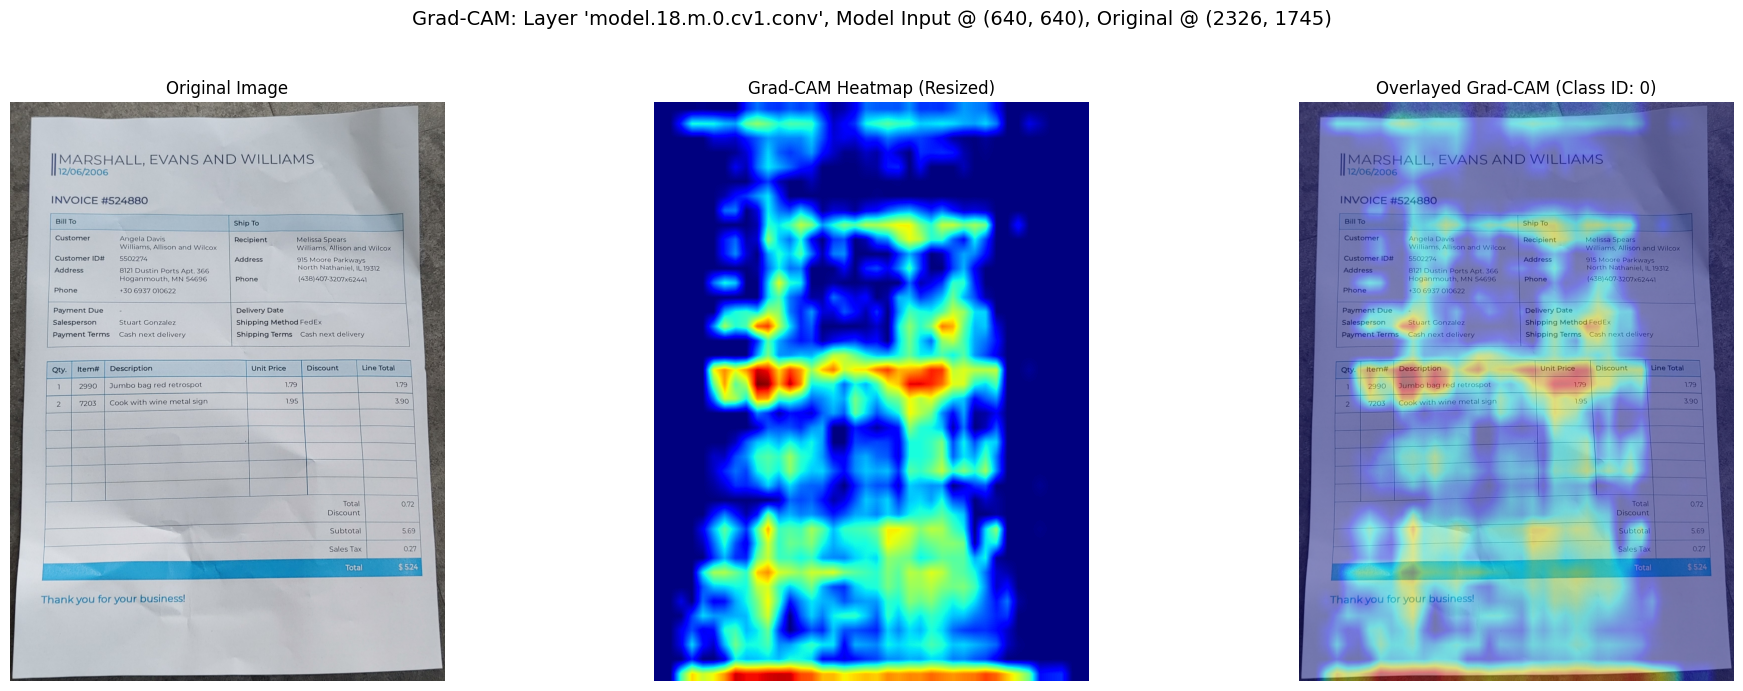

Visualisasi Matplotlib selesai.


In [47]:
if __name__ == '__main__':
    # Set device di awal
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Script akan berjalan di: {device}")

    # 1. Load model YOLO Anda
    model_path = "/kaggle/input/model_fix/other/default/1/best.pt"
    model_wrapper = None # Inisialisasi
    try:
        model_wrapper = YOLO(model_path) # Ini adalah objek YOLO wrapper
        # Pindahkan modul internal PyTorch (model.model) ke device yang diinginkan
        model_wrapper.model.to(device)
        model_wrapper.model.eval() # Pastikan model.model dalam mode evaluasi untuk GradCAM
        print(f"Model YOLO dimuat dari: {model_path}")
        first_param_device = next(model_wrapper.model.parameters()).device
        print(f"Modul internal model (model.model) ada di device: {first_param_device}")
    except Exception as e:
        print(f"Error memuat model YOLO: {e}")
        traceback.print_exc(); exit()

    # Tentukan target layer (Anda mungkin perlu verifikasi ulang nama layer ini)
    # Layer yang umum digunakan adalah layer konvolusi terakhir sebelum neck atau di akhir backbone
    # Contoh: model_wrapper.model.model[-2] atau layer spesifik dari print(model_wrapper.model)
    target_layer_name = "model.18.m.0.cv1.conv" # Verifikasi apakah ini layer yang tepat.
                                         # Biasanya layer yang lebih dalam (misal, model.21 atau model.17)
                                         # di akhir backbone atau di neck lebih sering dipakai.
                                         # "model.9" mungkin terlalu awal di backbone.
    print(f"Target layer name diatur ke: {target_layer_name}")


    # 2. Load dan preprocess gambar Anda
    image_path = "/kaggle/input/test-invoice/warped_document_crumpleseasy_bright.jpg"
    original_img_rgb = None # Inisialisasi
    try:
        original_img_bgr = cv2.imread(image_path)
        if original_img_bgr is None:
            raise FileNotFoundError(f"Gambar tidak ditemukan atau tidak bisa dibaca: {image_path}")
        original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)
        print(f"Gambar dimuat dari: {image_path}, shape asli: {original_img_rgb.shape}")
    except Exception as e:
        print(f"Error memuat gambar: {e}")
        traceback.print_exc(); exit()

    # Ukuran input yang akan digunakan oleh model YOLO dan Grad-CAM
    # Ini harus konsisten dengan bagaimana model dilatih atau biasanya digunakan untuk inferensi
    model_input_size = (640, 640) # (lebar, tinggi)
    print(f"Menggunakan ukuran input model: {model_input_size}")

    # Preprocess gambar ke ukuran input model
    img_resized_for_model = cv2.resize(original_img_rgb, model_input_size)
    img_normalized = img_resized_for_model / 255.0 # Normalisasi 0-1
    img_transposed = np.transpose(img_normalized, (2, 0, 1)) # HWC ke CHW
    # Pindahkan tensor input ke device yang sama dengan model
    img_tensor_for_model = torch.from_numpy(img_transposed).float().unsqueeze(0).to(device)

    print(f"Tensor input untuk model shape: {img_tensor_for_model.shape}, device: {img_tensor_for_model.device}")

    # 3. Tentukan target class ID
    target_class_id_for_gradcam = 0 # Ganti dengan ID kelas yang ingin Anda visualisasikan
    if hasattr(model_wrapper, 'names') and model_wrapper.names and target_class_id_for_gradcam < len(model_wrapper.names):
        print(f"Menargetkan kelas ID: {target_class_id_for_gradcam} ('{model_wrapper.names[target_class_id_for_gradcam]}') untuk Grad-CAM")
    else:
        print(f"Menargetkan kelas ID: {target_class_id_for_gradcam} (model.names tidak tersedia atau ID di luar jangkauan)")


    # 4. Buat instance GradCAM dan hasilkan heatmap
    heatmap_gradcam_on_model_input_size = None # Inisialisasi
    grad_cam_executor = None # Inisialisasi
    try:
        print("Menginisialisasi GradCAM...")
        # Pastikan kelas GradCAM Anda menerima objek YOLO wrapper atau nn.Module (model.model)
        # Jika GradCAM butuh nn.Module, gunakan: model_wrapper.model
        grad_cam_executor = GradCAM(model_wrapper, target_layer_name) # Sesuai kode Anda
        print("Menghasilkan heatmap Grad-CAM...")
        # GradCAM harus dijalankan pada tensor dengan ukuran input model
        heatmap_gradcam_on_model_input_size = grad_cam_executor(img_tensor_for_model, target_class_id_for_gradcam)
        
        if heatmap_gradcam_on_model_input_size is None:
            print("Grad-CAM tidak menghasilkan heatmap (None). Periksa implementasi GradCAM atau pemilihan layer/kelas.")
        else:
            print(f"Heatmap Grad-CAM (pada ukuran input model) dihasilkan. Shape: {heatmap_gradcam_on_model_input_size.shape}, Min: {heatmap_gradcam_on_model_input_size.min():.4f}, Max: {heatmap_gradcam_on_model_input_size.max():.4f}")

    except Exception as e:
        print(f"Terjadi error saat eksekusi Grad-CAM: {e}")
        traceback.print_exc()
    # --- Akhir blok Grad-CAM ---


    # 5. Visualisasi (JIKA heatmap berhasil dibuat)
    if heatmap_gradcam_on_model_input_size is not None and heatmap_gradcam_on_model_input_size.size > 0 :
        try:
            print("Memulai visualisasi heatmap Grad-CAM...")
            # Ukuran untuk menampilkan heatmap (sesuai gambar asli)
            display_heatmap_size = (original_img_rgb.shape[1], original_img_rgb.shape[0]) # (lebar, tinggi)

            # 1. Resize heatmap Grad-CAM (yang berukuran kecil, sesuai feature map target layer)
            #    ke ukuran input model (misal 640x640) terlebih dahulu.
            #    Implementasi GradCAM yang baik biasanya sudah mengembalikan heatmap yang telah di-upsample
            #    ke ukuran input_tensor (img_tensor_for_model). Jika belum, Anda perlu resize manual di sini.
            #    Asumsi heatmap_gradcam_on_model_input_size sudah di-upsample ke model_input_size.
            #    Jika masih berukuran kecil (misal 20x20), maka resize ke model_input_size dulu.
            if heatmap_gradcam_on_model_input_size.shape[0] != model_input_size[1] or \
               heatmap_gradcam_on_model_input_size.shape[1] != model_input_size[0]:
                print(f"Merubah ukuran heatmap dari {heatmap_gradcam_on_model_input_size.shape} ke {model_input_size} (model input size)...")
                heatmap_at_model_input_size = cv2.resize(heatmap_gradcam_on_model_input_size, model_input_size, interpolation=cv2.INTER_LINEAR)
            else:
                heatmap_at_model_input_size = heatmap_gradcam_on_model_input_size
            
            # 2. Sekarang resize heatmap (yang sudah seukuran input model) ke ukuran gambar asli untuk display
            heatmap_resized_for_display = cv2.resize(heatmap_at_model_input_size, display_heatmap_size, interpolation=cv2.INTER_LINEAR)
            print(f"Heatmap diubah ukurannya untuk display ke: {heatmap_resized_for_display.shape}")

            # Normalisasi lagi jika perlu (setelah resize, nilai mungkin sedikit berubah)
            if heatmap_resized_for_display.max() > 0:
                heatmap_resized_for_display = heatmap_resized_for_display / heatmap_resized_for_display.max()

            heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized_for_display), cv2.COLORMAP_JET)
            print(f"Heatmap berwarna dibuat. Shape: {heatmap_colored.shape}")

            # Overlay dengan gambar asli (RGB)
            overlayed_image_rgb = cv2.addWeighted(original_img_rgb, 0.6, cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB), 0.4, 0)
            print("Gambar overlay dibuat.")
            
            # Tampilkan menggunakan Matplotlib
            plt.figure(figsize=(20, 7)) # Lebih lebar untuk 3 gambar

            plt.subplot(1, 3, 1)
            plt.imshow(original_img_rgb)
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(heatmap_resized_for_display, cmap='jet') # Tampilkan heatmap yang sudah di-resize ke ukuran asli
            plt.title("Grad-CAM Heatmap (Resized)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(overlayed_image_rgb) # Tampilkan overlay RGB
            plt.title(f"Overlayed Grad-CAM (Class ID: {target_class_id_for_gradcam})")
            plt.axis("off")
            
            plt.suptitle(f"Grad-CAM: Layer '{target_layer_name}', Model Input @ {model_input_size}, Original @ {original_img_rgb.shape[:2]}", fontsize=14)
            plt.tight_layout(rect=[0, 0, 1, 0.95]) # Sesuaikan rect untuk suptitle
            plt.show()
            print("Visualisasi Matplotlib selesai.")

        except Exception as e_vis:
            print(f"Error saat visualisasi Grad-CAM: {e_vis}")
            traceback.print_exc()
    else:
        print("Heatmap Grad-CAM kosong atau None, visualisasi dilewati.")

# SAILENCY MAP

In [36]:
import torch
import cv2
import numpy as np
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO

In [37]:
try:
    model = YOLO('/kaggle/input/model_fix/other/default/1/best.pt')
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    exit()

In [38]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((640, 640)), 
        transforms.ToTensor(),
    ])
    img_tensor = transform(image)
    return image, img_tensor.unsqueeze(0)

In [39]:
import torch
import numpy as np
import gc
import traceback # Untuk mencetak traceback lengkap jika ada Python exception

# ... (fungsi preprocess_image, visualize_saliency, dan load model Anda) ...

def generate_saliency_map(pytorch_module, input_image_tensor, target_class_idx_for_saliency=0):
    saliency_np = None
    try:
        print("[SALIENCY DEBUG] Memulai generate_saliency_map...")
        device = next(pytorch_module.parameters()).device
        print(f"[SALIENCY DEBUG] Model (pytorch_module) ada di perangkat: {device}")

        input_image_tensor = input_image_tensor.to(device)
        if not input_image_tensor.requires_grad:
            input_image_tensor.requires_grad_(True)
        print(f"[SALIENCY DEBUG] input_image_tensor dipindahkan ke {device} dan requires_grad={input_image_tensor.requires_grad}")

        original_training_mode = pytorch_module.training
        print(f"[SALIENCY DEBUG] Mode training asli modul: {original_training_mode}")
        raw_predictions = None
        try:
            pytorch_module.train()
            print("[SALIENCY DEBUG] Mode modul diubah ke train(). Melakukan forward pass...")
            raw_predictions = pytorch_module(input_image_tensor)
            print("[SALIENCY DEBUG] Forward pass selesai.")
        finally:
            pytorch_module.train(original_training_mode)
            print(f"[SALIENCY DEBUG] Mode training modul dikembalikan ke: {original_training_mode}")

        if raw_predictions is None:
            print("[SALIENCY ERROR] raw_predictions adalah None setelah forward pass.")
            return None
        
        print("[SALIENCY DEBUG] Memilih target_score...")
        target_score = None
        # Menggunakan nama variabel yang berbeda untuk menghindari kebingungan dengan tensor yang dihapus
        main_pred_tensor_from_raw = None 
        
        if isinstance(raw_predictions, (tuple, list)) and len(raw_predictions) > 0 and isinstance(raw_predictions[0], torch.Tensor):
            main_pred_tensor_from_raw = raw_predictions[0]
            if len(raw_predictions) > 1: del raw_predictions[1:] # Hapus sisa jika ada
        elif isinstance(raw_predictions, torch.Tensor):
            main_pred_tensor_from_raw = raw_predictions
        
        del raw_predictions # Hapus variabel raw_predictions asli
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        print("[SALIENCY DEBUG] Referensi raw_predictions (variabel) dihapus dan cache dikosongkan.")

        if main_pred_tensor_from_raw is not None:
            print(f"[SALIENCY DEBUG] Shape main_pred_tensor_from_raw: {main_pred_tensor_from_raw.shape}") # Harusnya [1, 66, 80, 80]

            # --- KOREKSI LOGIKA TARGET SCORE untuk shape [B, C, H, W] ---
            # C = 66. Asumsi: 4 (bbox) + 1 (objectness) + 61 (classes)
            obj_score_channel_idx = 4
            class_scores_start_channel_idx = 5

            if target_class_idx_for_saliency is not None:
                actual_channel_for_class = class_scores_start_channel_idx + target_class_idx_for_saliency
                # Pastikan channel index valid untuk dimensi ke-1 (channels)
                if main_pred_tensor_from_raw.shape[1] > actual_channel_for_class:
                    target_score = main_pred_tensor_from_raw[0, actual_channel_for_class, :, :].sum()
                    print(f"[SALIENCY DEBUG] Menggunakan jumlah skor (sum over H,W) untuk kelas {target_class_idx_for_saliency} (channel: {actual_channel_for_class}) sebagai target.")
                else:
                    print(f"[SALIENCY WARNING] Channel untuk kelas target ({actual_channel_for_class}) di luar jangkauan channel ({main_pred_tensor_from_raw.shape[1]}). Jatuh kembali ke skor objectness.")
                    if main_pred_tensor_from_raw.shape[1] > obj_score_channel_idx:
                        target_score = main_pred_tensor_from_raw[0, obj_score_channel_idx, :, :].sum()
                        print(f"[SALIENCY DEBUG] Menggunakan jumlah skor objectness (channel: {obj_score_channel_idx}) sebagai target (fallback).")
                    else:
                        print(f"[SALIENCY ERROR] Channel objectness ({obj_score_channel_idx}) juga di luar jangkauan.")
                        target_score = None 
            elif main_pred_tensor_from_raw.shape[1] > obj_score_channel_idx: # Default jika tidak ada kelas target
                target_score = main_pred_tensor_from_raw[0, obj_score_channel_idx, :, :].sum()
                print(f"[SALIENCY DEBUG] Menggunakan jumlah skor objectness (channel: {obj_score_channel_idx}) sebagai target (default).")
            
            if target_score is not None:
                 print(f"[SALIENCY DEBUG] target_score (sebelum backward) dihitung. Nilai: {target_score.item()}")
            else:
                print(f"[SALIENCY ERROR] Gagal menghitung target_score dari main_pred_tensor_from_raw.")
        else:
            print("[SALIENCY ERROR] Tidak dapat mengidentifikasi tensor prediksi utama (main_pred_tensor_from_raw is None).")
            if main_pred_tensor_from_raw is not None: del main_pred_tensor_from_raw
            gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
            return None
        
        if main_pred_tensor_from_raw is not None: del main_pred_tensor_from_raw
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        print("[SALIENCY DEBUG] Referensi main_pred_tensor_from_raw dihapus dan cache dikosongkan.")

        if target_score is None or (isinstance(target_score, torch.Tensor) and target_score.numel() == 0) :
            print("[SALIENCY ERROR] target_score tidak valid atau kosong.")
            return None

        print("[SALIENCY DEBUG] Akan melakukan zero_grad pada modul...")
        pytorch_module.zero_grad()
        if input_image_tensor.grad is not None:
            print("[SALIENCY DEBUG] Meng-nol-kan gradien input_image_tensor yang ada...")
            input_image_tensor.grad.zero_()
        
        print("[SALIENCY DEBUG] Akan melakukan target_score.backward()...")
        target_score.backward()
        print("[SALIENCY DEBUG] target_score.backward() selesai.")

        del target_score
        gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
        print("[SALIENCY DEBUG] target_score dihapus dan cache dikosongkan.")

        grad_tensor = input_image_tensor.grad # Simpan referensi ke gradien
        if grad_tensor is None:
            print("[SALIENCY ERROR] input_image_tensor.grad adalah None setelah backward().")
            return None
        print(f"[SALIENCY DEBUG] input_image_tensor.grad berhasil didapatkan. Shape: {grad_tensor.shape}, Device: {grad_tensor.device}")

        # --- BAGIAN YANG SEBELUMNYA MENYEBABKAN KERNEL MATI ---
        # Kita akan memecah setiap operasi dan menambah try-except yang sangat spesifik
        saliency_abs_grad = None
        saliency_max_channels = None
        saliency_squeezed = None
        saliency_cpu = None
        
        try:
            print("[SALIENCY DEBUG TRY-BLOCK] Memulai pemrosesan gradien...")
            print("[SALIENCY DEBUG STEP] Menghitung .abs() pada gradien...")
            saliency_abs_grad = grad_tensor.abs()
            print(f"[SALIENCY DEBUG STEP] .abs() selesai. Shape: {saliency_abs_grad.shape}, Device: {saliency_abs_grad.device}")

            print("[SALIENCY DEBUG STEP] Menghitung torch.max(..., dim=1)...")
            saliency_max_channels, _ = torch.max(saliency_abs_grad, dim=1)
            print(f"[SALIENCY DEBUG STEP] torch.max() selesai. Shape: {saliency_max_channels.shape}, Device: {saliency_max_channels.device}")
            del saliency_abs_grad; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None # Hapus segera

            print("[SALIENCY DEBUG STEP] Menghitung .squeeze(0)...")
            saliency_squeezed = saliency_max_channels.squeeze(0)
            print(f"[SALIENCY DEBUG STEP] .squeeze(0) selesai. Shape: {saliency_squeezed.shape}, Device: {saliency_squeezed.device}")
            del saliency_max_channels; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None

            print("[SALIENCY DEBUG STEP] Memindahkan ke CPU (.cpu())...")
            saliency_cpu = saliency_squeezed.cpu()
            print(f"[SALIENCY DEBUG STEP] .cpu() selesai. Shape: {saliency_cpu.shape}, Device: {saliency_cpu.device}")
            del saliency_squeezed; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None

            print("[SALIENCY DEBUG STEP] Mengkonversi ke NumPy (.numpy())...")
            saliency_np = saliency_cpu.numpy()
            print("[SALIENCY DEBUG STEP] .numpy() selesai. Saliency map (saliency_np) berhasil dibuat.")
            del saliency_cpu; gc.collect()

        except RuntimeError as e_runtime: # Menangkap error PyTorch yang umum
            print(f"[SALIENCY ERROR RUNTIME] Saat memproses gradien: {e_runtime}")
            traceback.print_exc()
            return None
        except Exception as e_general: # Menangkap error Python lainnya
            print(f"[SALIENCY ERROR GENERAL] Saat memproses gradien: {e_general}")
            traceback.print_exc()
            # Jika kernel mati karena error level C atau CUDA, ini mungkin tidak tertangkap.
            return None

        if saliency_np is None:
             print("[SALIENCY ERROR] saliency_np adalah None sebelum normalisasi (kemungkinan error di atas).")
             return None

        print("[SALIENCY DEBUG] Memulai normalisasi saliency_np...")
        saliency_min = saliency_np.min()
        saliency_max = saliency_np.max()
        if saliency_max - saliency_min > 1e-8:
            saliency_np = (saliency_np - saliency_min) / (saliency_max - saliency_min)
        else:
            saliency_np = np.zeros_like(saliency_np)
        saliency_np = np.uint8(saliency_np * 255)
        print("[SALIENCY DEBUG] Saliency map dinormalisasi.")
        

        return saliency_np

    except Exception as e_main: # Error utama dalam fungsi
        print(f"[SALIENCY ERROR UTAMA] Terjadi error di generate_saliency_map: {e_main}")
        traceback.print_exc()
        return None
    finally:
        # Pembersihan akhir
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        print("[SALIENCY DEBUG] Pembersihan akhir di generate_saliency_map selesai.")

# ... (sisa skrip __main__ Anda)

In [40]:
import cv2
import numpy as np
# import matplotlib.pyplot as plt # Jika ingin menampilkan dengan matplotlib
# from IPython.display import Image as IPImage, display # Jika ingin menampilkan dengan IPython

def visualize_saliency(original_image, saliency_map, detection_results=None,
                       model_input_size=(640, 640), # Tambahkan argumen untuk ukuran input model
                       alpha=0.5, output_path_prefix="saliency_output"):
    """
    Memvisualisasikan saliency map, menggambar bounding box yang diskalakan, dan menyimpannya ke file.
    Args:
        original_image (PIL.Image): Gambar asli (objek PIL Image).
        saliency_map (numpy.ndarray): Saliency map (grayscale, uint8, 0-255).
        detection_results (ultralytics.engine.results.Results, optional): Hasil deteksi dari YOLO.
        model_input_size (tuple, optional): Ukuran (lebar, tinggi) gambar saat dimasukkan ke model.
        alpha (float, optional): Transparansi heatmap.
        output_path_prefix (str, optional): Prefix untuk nama file output.
    """
    if saliency_map is None:
        print("[VISUALIZE] Saliency map tidak tersedia untuk visualisasi.")
        return

    print(f"[VISUALIZE] Tipe data saliency_map: {saliency_map.dtype}, Shape: {saliency_map.shape}")
    if saliency_map.dtype != np.uint8:
        print("[VISUALIZE] PERINGATAN: Tipe data saliency_map bukan np.uint8.")
        # Coba konversi (asumsi sudah dinormalisasi 0-1 jika float, atau perlu cast langsung)
        if saliency_map.max() <= 1.0 and saliency_map.min() >= 0.0 and saliency_map.dtype != np.uint8:
             saliency_map = np.uint8(saliency_map * 255)
        else:
             saliency_map = saliency_map.astype(np.uint8)
        print(f"[VISUALIZE] Saliency map dikonversi/di-cast ke uint8. Shape baru: {saliency_map.shape}")

    if len(saliency_map.shape) != 2: # Pastikan 2D
        print(f"[VISUALIZE] PERINGATAN: Saliency map shape {saliency_map.shape} bukan 2D.")
        if len(saliency_map.shape) == 3 and saliency_map.shape[2] == 1: saliency_map = saliency_map.squeeze()
        elif len(saliency_map.shape) == 3: saliency_map = cv2.cvtColor(saliency_map, cv2.COLOR_BGR2GRAY) # Jika berwarna
        else: print("[VISUALIZE] ERROR: Tidak bisa mengubah saliency_map menjadi 2D."); return
        print(f"[VISUALIZE] Shape saliency_map setelah penyesuaian: {saliency_map.shape}")

    try:
        pil_original_width = original_image.width
        pil_original_height = original_image.height
        print(f"[VISUALIZE] Ukuran gambar asli (PIL): Width={pil_original_width}, Height={pil_original_height}")

        saliency_map_resized = cv2.resize(saliency_map, (pil_original_width, pil_original_height))
        print(f"[VISUALIZE] Saliency map diubah ukurannya menjadi: {saliency_map_resized.shape}")

        heatmap = cv2.applyColorMap(saliency_map_resized, cv2.COLORMAP_JET)
        print(f"[VISUALIZE] Heatmap dibuat. Shape: {heatmap.shape}")

        original_cv_image = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
        print(f"[VISUALIZE] Gambar asli dikonversi ke OpenCV BGR. Shape: {original_cv_image.shape}")

        overlaid_image = cv2.addWeighted(original_cv_image, 1 - alpha, heatmap, alpha, 0)
        print(f"[VISUALIZE] Heatmap di-overlay ke gambar asli. Shape: {overlaid_image.shape}")

        # Gambar bounding box jika ada hasil deteksi
        if detection_results and hasattr(detection_results, 'boxes') and len(detection_results.boxes) > 0:
            model_input_width, model_input_height = model_input_size
            
            # Hitung faktor skala
            scale_x = pil_original_width / model_input_width
            scale_y = pil_original_height / model_input_height
            print(f"[VISUALIZE] Menggambar {len(detection_results.boxes)} bounding box dengan skala x:{scale_x:.2f}, y:{scale_y:.2f}")

            names = detection_results.names if hasattr(detection_results, 'names') else {int(c): f"class_{int(c)}" for c in detection_results.boxes.cls.unique()}

            for i in range(len(detection_results.boxes)):
                box_data = detection_results.boxes[i]
                # Koordinat xyxy dari model berada dalam ruang input model (misal, 640x640)
                xyxy_model_space = box_data.xyxy.squeeze().cpu().numpy()
                conf = box_data.conf.squeeze().cpu().numpy()
                cls_id = int(box_data.cls.squeeze().cpu().numpy())

                # Skalakan koordinat ke ruang gambar asli
                orig_x1_scaled = xyxy_model_space[0] * scale_x
                orig_y1_scaled = xyxy_model_space[1] * scale_y
                orig_x2_scaled = xyxy_model_space[2] * scale_x
                orig_y2_scaled = xyxy_model_space[3] * scale_y
                
                # Konversi ke integer dan klip ke batas gambar asli
                x1 = max(0, min(int(orig_x1_scaled), pil_original_width - 1))
                y1 = max(0, min(int(orig_y1_scaled), pil_original_height - 1))
                x2 = max(0, min(int(orig_x2_scaled), pil_original_width - 1))
                y2 = max(0, min(int(orig_y2_scaled), pil_original_height - 1))
                
                label = f"{names.get(cls_id, f'class_{cls_id}')}: {conf:.2f}"

                cv2.rectangle(overlaid_image, (x1, y1), (x2, y2), (0, 255, 0), 2) # Warna hijau (BGR)
                cv2.putText(overlaid_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print("[VISUALIZE] Bounding box selesai digambar dengan koordinat yang diskalakan.")
        else:
            print("[VISUALIZE] Tidak ada hasil deteksi valid untuk digambar bounding boxnya.")

        original_filename = f"{output_path_prefix}_original.png"
        heatmap_filename = f"{output_path_prefix}_heatmap.png"
        overlaid_filename = f"{output_path_prefix}_overlaid.png"

        cv2.imwrite(original_filename, original_cv_image)
        print(f"[VISUALIZE] Gambar asli disimpan ke: {original_filename}")
        cv2.imwrite(heatmap_filename, heatmap)
        print(f"[VISUALIZE] Heatmap disimpan ke: {heatmap_filename}")
        cv2.imwrite(overlaid_filename, overlaid_image)
        print(f"[VISUALIZE] Gambar overlaid disimpan ke: {overlaid_filename}")
        print("[VISUALIZE] Semua gambar berhasil disimpan.")

        # (Opsional: kode untuk menampilkan dengan matplotlib jika di notebook)
        # import matplotlib.pyplot as plt
        # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # ax.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
        # ax.set_title("Overlaid Image with Scaled BBoxes")
        # ax.axis('off')
        # plt.show()


    except Exception as e:
        print(f"[VISUALIZE] Terjadi error dalam fungsi visualize_saliency: {e}")
        import traceback
        traceback.print_exc()

In [41]:
MODEL_INPUT_WIDTH = 640
MODEL_INPUT_HEIGHT = 640

# --- Main Execution ---
if __name__ == "__main__":
    IMAGE_PATH = '/kaggle/input/test-invoice/warped_document_crumpleseasy_bright.jpg'

    # Muat model YOLOv8 Anda (pastikan 'model' sudah didefinisikan sebagai objek YOLO)
    # Contoh: model = YOLO('yolov8n.pt') atau model custom Anda
    # Jika model Anda adalah model custom yang mendeteksi "table" sebagai kelas 0, pastikan itu yang dimuat.
    # model = YOLO('path/to/your/custom_model_detecting_table.pt') # GANTI JIKA PERLU

    try:
        original_image, image_tensor = preprocess_image(IMAGE_PATH) # Fungsi preprocess_image Anda
        print(f"Image tensor shape awal: {image_tensor.shape}, device: {image_tensor.device}")
    except FileNotFoundError:
        print(f"Error: File gambar tidak ditemukan di {IMAGE_PATH}")
        exit()
    except Exception as e:
        print(f"Error saat memproses gambar: {e}")
        exit()

    # Dapatkan hasil deteksi aktual dari model.predict() untuk visualisasi nanti
    # dan untuk mengetahui apa yang sebenarnya dideteksi.
    print("\nMemeriksa hasil prediksi model secara langsung (untuk visualisasi)...")
    detection_results_for_visualization = None
    try:
        # Pastikan 'model' adalah objek YOLO yang sudah dimuat
        raw_results_list = model.predict(image_tensor, verbose=False) # verbose=False agar tidak terlalu ramai
        if raw_results_list and len(raw_results_list) > 0:
            detection_results_for_visualization = raw_results_list[0] # Ambil objek Results pertama
            num_detections = len(detection_results_for_visualization.boxes)
            print(f"Model mendeteksi {num_detections} objek untuk visualisasi.")
            if num_detections > 0:
                 print(f"  Contoh deteksi: conf={detection_results_for_visualization.boxes.conf[0].item():.2f}, cls={int(detection_results_for_visualization.boxes.cls[0].item())}")
        else:
            print("Model tidak memberikan hasil prediksi untuk visualisasi.")
    except Exception as e:
        print(f"Error saat menjalankan model.predict() untuk visualisasi: {e}")

    # --- Generate saliency map ---
    # Kita tahu kelas 0 ("table") terdeteksi. Mari kita coba jelaskan kelas ini.
    # Panggil dengan pytorch_module (model.model) dan image_tensor
    # Fungsi generate_saliency_map akan menangani pemindahan tensor ke device yang benar
    print("\nMemulai pembuatan saliency map...")
    saliency_map_np = generate_saliency_map(
        pytorch_module=model.model,  # Ini adalah nn.Module
        input_image_tensor=image_tensor,
        target_class_idx_for_saliency=0  # Jelaskan kelas 0 ("table")
    )

    if saliency_map_np is not None:
        print("Saliency map berhasil dibuat.")
        visualize_saliency(
            original_image, # Objek PIL Image asli
            saliency_map_np,
            detection_results_for_visualization, # Hasil dari model.predict()
            model_input_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT) # <-- Berikan ukuran ini
        )
    else:
        print("Gagal membuat saliency map.")

Image tensor shape awal: torch.Size([1, 3, 640, 640]), device: cpu

Memeriksa hasil prediksi model secara langsung (untuk visualisasi)...
Model mendeteksi 1 objek untuk visualisasi.
  Contoh deteksi: conf=0.92, cls=0

Memulai pembuatan saliency map...
[SALIENCY DEBUG] Memulai generate_saliency_map...
[SALIENCY DEBUG] Model (pytorch_module) ada di perangkat: cpu
[SALIENCY DEBUG] input_image_tensor dipindahkan ke cpu dan requires_grad=True
[SALIENCY DEBUG] Mode training asli modul: False
[SALIENCY DEBUG] Mode modul diubah ke train(). Melakukan forward pass...
[SALIENCY DEBUG] Forward pass selesai.
[SALIENCY DEBUG] Mode training modul dikembalikan ke: False
[SALIENCY DEBUG] Memilih target_score...
[SALIENCY DEBUG] Referensi raw_predictions (variabel) dihapus dan cache dikosongkan.
[SALIENCY DEBUG] Shape main_pred_tensor_from_raw: torch.Size([1, 66, 80, 80])
[SALIENCY DEBUG] Menggunakan jumlah skor (sum over H,W) untuk kelas 0 (channel: 5) sebagai target.
[SALIENCY DEBUG] target_score (seb